In [119]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import FreqDist
import text2emotion as te
from LeXmo import LeXmo
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [120]:
df = pd.read_csv('data/data.csv')

In [121]:
df.head()

,Speech,Speech Word Frequency,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,NumWords,SpeechNormalize
0,trump: wow. whoa. that group people. thousands...,<FreqDist with 922 samples and 2793 outcomes>,0.013828,0.033187,0.005992,0.013137,0.026043,0.027887,0.070754,0.014750,0.028578,0.042637,3443,trump wow whoa that group people thousands nic...
1,good evening. thank much speak today lifelong ...,<FreqDist with 608 samples and 1166 outcomes>,0.025760,0.046235,0.011889,0.035667,0.038309,0.044914,0.065390,0.025760,0.032365,0.058124,1273,good evening thank much speak today lifelong s...
2,"thank opportunity speak you, thank center nati...",<FreqDist with 948 samples and 1745 outcomes>,0.016202,0.039154,0.005851,0.027903,0.030603,0.054005,0.076058,0.013951,0.012601,0.055806,1911,thank opportunity speak you thank center natio...
3,thank joining today. this going speech hillary...,<FreqDist with 742 samples and 1539 outcomes>,0.038164,0.023724,0.015988,0.050542,0.013925,0.061888,0.051057,0.030944,0.011862,0.040227,1670,thank joining today this going speech hillary ...
4,today like share thoughts stakes election. peo...,<FreqDist with 877 samples and 1751 outcomes>,0.025103,0.041077,0.011410,0.031949,0.022364,0.052487,0.063441,0.026472,0.016431,0.053400,1891,today like share thoughts stakes election peop...


In [122]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(df['SpeechNormalize'], 30):
    words.append(i)
    word_values.append(j)

In [123]:
df['lengthSentence'] = df['SpeechNormalize'].apply(len)

In [124]:
def mostFreqWords(i):
    mostFreq = {k:0 for k in words}
    for key, value in mostFreq.items():
        value = df.iloc[i]['SpeechNormalize'].count(key)
        mostFreq[key] = value
    return pd.DataFrame.from_dict(mostFreq,orient='index').T

In [125]:
dataFreq = pd.DataFrame()
for i in range(df.shape[0]):
    dd = mostFreqWords(i)
    dataFreq = pd.concat([dataFreq,dd],axis=0)

dataFreq.reset_index(inplace=True, drop=True)
df = pd.concat([df,dataFreq], axis=1)


In [126]:
col = list(dataFreq.columns.values)
col.append('lengthSentence')

In [128]:
data = df[col]

/var/folders/d4/d917y7xs6qs303lp95st4lzr0000gn/T/ipykernel_8639/4230218891.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(bins=5, ax=ax)


array([[<AxesSubplot:title={'center':'going'}>,
        <AxesSubplot:title={'center':'people'}>,
        <AxesSubplot:title={'center':'country'}>,
        <AxesSubplot:title={'center':'clinton'}>,
        <AxesSubplot:title={'center':'hillary'}>,
        <AxesSubplot:title={'center':'american'}>],
       [<AxesSubplot:title={'center':'jobs'}>,
        <AxesSubplot:title={'center':'america'}>,
        <AxesSubplot:title={'center':'know'}>,
        <AxesSubplot:title={'center':'great'}>,
        <AxesSubplot:title={'center':'new'}>,
        <AxesSubplot:title={'center':'said'}>],
       [<AxesSubplot:title={'center':'make'}>,
        <AxesSubplot:title={'center':'want'}>,
        <AxesSubplot:title={'center':'like'}>,
        <AxesSubplot:title={'center':'right'}>,
        <AxesSubplot:title={'center':'trump'}>,
        <AxesSubplot:title={'center':'time'}>],
       [<AxesSubplot:title={'center':'president'}>,
        <AxesSubplot:title={'center':'world'}>,
        <AxesSubplot:title={'c

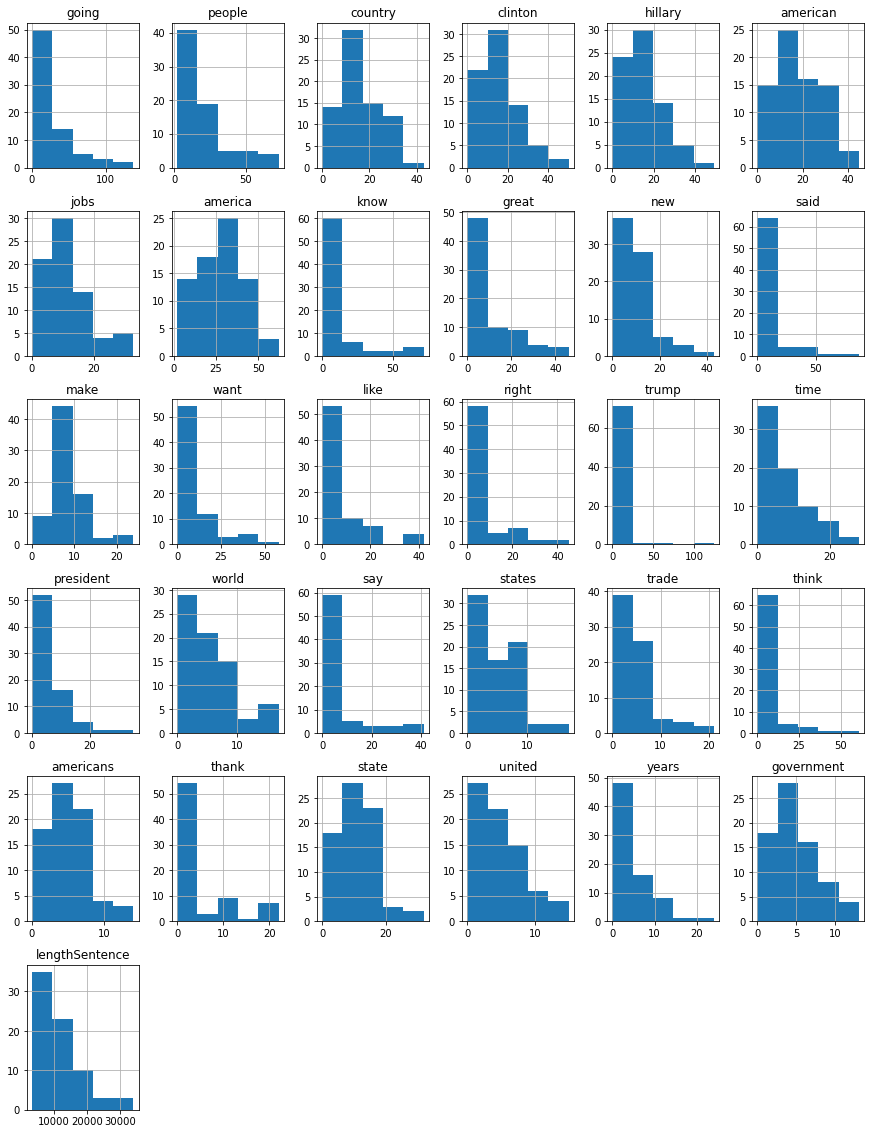

In [136]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(bins=5, ax=ax)


In [141]:
## We are predicting length of sentences based on top freq words
formula = "lengthSentence ~ going + trump + time + jobs + new + clinton:hillary + \
           people*country + american:america:americans + president + make:great + \
           united:states + government:state + years + thank:think:say:know:right:like:want:said + trade*world"

In [142]:
mask = np.random.rand(len(data)) < 0.8
df_train = data[mask]
df_test = data[~mask]


In [144]:
import patsy
y_train, X_train = patsy.dmatrices(formula, df_train, return_type = 'dataframe')
y_test, X_test = patsy.dmatrices(formula, df_test, return_type = 'dataframe')

### NegativeBinomial

In [160]:
# Regression

nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 1)).fit()

print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         lengthSentence   No. Observations:                   60
Model:                            GLM   Df Residuals:                       40
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -614.03
Date:                Thu, 08 Dec 2022   Deviance:                       1.0270
Time:                        20:39:01   Pearson chi2:                     1.01
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1881
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

## Use the model to predict y's of the train set

In [161]:
nb_prediction_train = nb_training_results.get_prediction(X_train)

nb_summary_frame_train = nb_prediction_train.summary_frame()

predicted_counts_train = nb_summary_frame_train['mean']
# Accuracy of the train set

print("R-square of train set: ", round(r2_score(y_train, predicted_counts_train)*100, 2), "%")


R-square of train set:  95.15 %


## Use the model to predict y's of the test set

In [162]:
nb_prediction_test = nb_training_results.get_prediction(X_test)

nb_summary_frame_test = nb_prediction_test.summary_frame()

predicted_counts = nb_summary_frame_test['mean']

#Accuracy of the test set

print("R-square of test set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

R-square of train set:  71.33 %


## Plot predited y's versus actual y's of the test set

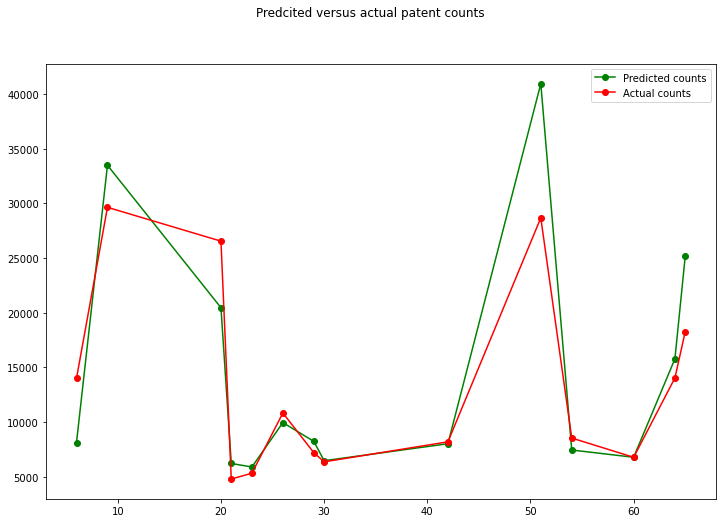

In [163]:
fig = plt.figure(figsize = (12, 8))

fig.suptitle('Predcited versus actual patent counts')

predicted, = plt.plot(X_test.index, predicted_counts , 'go-', label = 'Predicted counts')
actual, = plt.plot(X_test.index, y_test['lengthSentence'] , 'ro-', label = 'Actual counts')


plt.legend(handles = [predicted, actual])
plt.show()


## Poisson

In [159]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [164]:
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.Poisson()).fit()

print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         lengthSentence   No. Observations:                   60
Model:                            GLM   Df Residuals:                       40
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4726.9
Date:                Thu, 08 Dec 2022   Deviance:                       8790.1
Time:                        20:39:58   Pearson chi2:                 8.75e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [165]:
nb_prediction_train = nb_training_results.get_prediction(X_train)

nb_summary_frame_train = nb_prediction_train.summary_frame()

predicted_counts_train = nb_summary_frame_train['mean']
# Accuracy of the train set

print("R-square of train set: ", round(r2_score(y_train, predicted_counts_train)*100, 2), "%")


R-square of train set:  96.0 %


In [166]:
nb_prediction_test = nb_training_results.get_prediction(X_test)

nb_summary_frame_test = nb_prediction_test.summary_frame()

predicted_counts = nb_summary_frame_test['mean']

#Accuracy of the test set

print("R-square of test set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

R-square of train set:  56.31 %


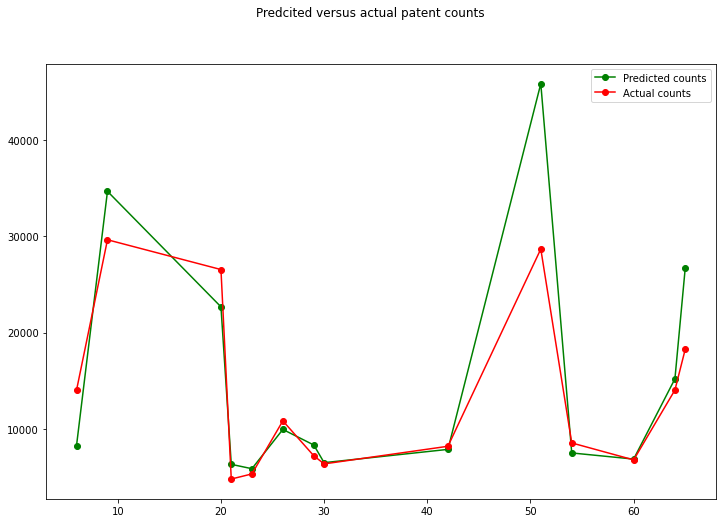

In [168]:
fig = plt.figure(figsize = (12, 8))

fig.suptitle('Predcited versus actual patent counts')

predicted, = plt.plot(X_test.index, predicted_counts , 'go-', label = 'Predicted counts')
actual, = plt.plot(X_test.index, y_test['lengthSentence'] , 'ro-', label = 'Actual counts')


plt.legend(handles = [predicted, actual])
plt.show()


In [171]:
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.Gaussian()).fit()

print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         lengthSentence   No. Observations:                   60
Model:                            GLM   Df Residuals:                       40
Model Family:                Gaussian   Df Model:                           19
Link Function:               identity   Scale:                      2.0959e+06
Method:                          IRLS   Log-Likelihood:                -509.64
Date:                Thu, 08 Dec 2022   Deviance:                   8.3836e+07
Time:                        20:45:24   Pearson chi2:                 8.38e+07
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [172]:
nb_prediction_train = nb_training_results.get_prediction(X_train)

nb_summary_frame_train = nb_prediction_train.summary_frame()

predicted_counts_train = nb_summary_frame_train['mean']
# Accuracy of the train set

print("R-square of train set: ", round(r2_score(y_train, predicted_counts_train)*100, 2), "%")


R-square of train set:  95.9 %


In [173]:
nb_prediction_test = nb_training_results.get_prediction(X_test)

nb_summary_frame_test = nb_prediction_test.summary_frame()

predicted_counts = nb_summary_frame_test['mean']

#Accuracy of the test set

print("R-square of test set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

R-square of train set:  94.62 %


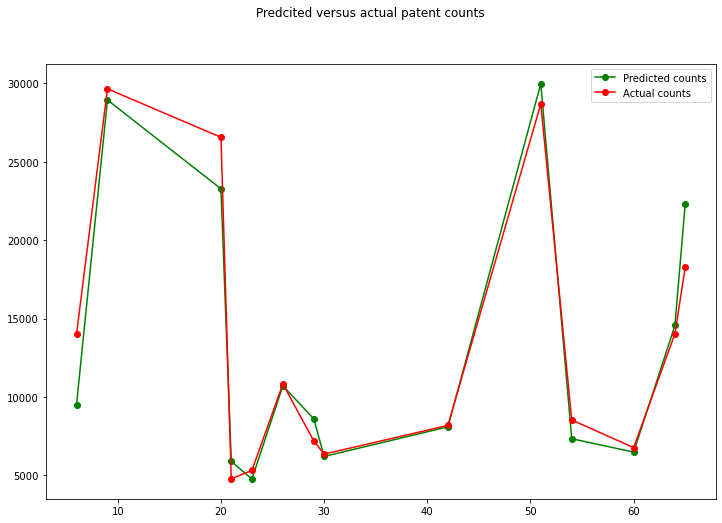

In [174]:
fig = plt.figure(figsize = (12, 8))

fig.suptitle('Predcited versus actual patent counts')

predicted, = plt.plot(X_test.index, predicted_counts , 'go-', label = 'Predicted counts')
actual, = plt.plot(X_test.index, y_test['lengthSentence'] , 'ro-', label = 'Actual counts')


plt.legend(handles = [predicted, actual])
plt.show()


1. Possion
2. Negative Binomila
3. Gaussaian
